In [26]:
import  warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision
from torch import optim
from torch import cuda
from torch.optim.lr_scheduler import CosineAnnealingLR

#import torch_xla
#import torch_xla.core.xla_model as xm

import time, gc, random
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer
stop_words = get_stop_words('en')
stop_words.append(' ')
stop_words.append('')

In [2]:
random.seed(2020)
np.random.seed(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X


In [146]:
class MLPClass(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_size, 300),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, 100),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, output_size)
        )
        
            
        
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.fc(x)
        x= self.sigmoid(x)
        return x

In [165]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        pred_0 = pred[target<0.5]
        target_0 = target[target<0.5]
        loss_0 = self.mse(pred_0, target_0)
        #loss_0 = self.mse(pred, target)
        
        
        pred_1 = pred[target>0.5]
        target_1 = target[target>0.5]
        loss_1 = self.mse(pred_1, target_1)
        loss_1 = self.mse(pred, target) if torch.isnan(loss_1) else loss_1

        loss = loss_0 + loss_1
        
        return loss, loss_1

In [148]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
        
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.X)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        # argumentation
        x = torch.FloatTensor(self.X[index])
        if self.y!=None:
            return {
                'input': x,
                'label': torch.FloatTensor(self.y[index])
            }
        else:
            return {
                'input': x
            }

In [149]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / np.sqrt(label_to_count[self._get_label(dataset, idx)])
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        """if isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        elif self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            raise NotImplementedError"""
        return dataset.y[idx][0]
        
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [150]:
feature = ['abil', 'abl', 'accept', 'access', 'accord', 'account', 'accur', 'accuraci', 'achiev', 'acquisit', 'across', 'act', 'action', 
           'activ', 'ad', 'addit', 'address', 'adher', 'administr', 'advanc', 'advis', 'advisor', 'agil', 'agre', 'ai', 'algorithm', 
           'align', 'analys', 'analysi', 'analyst', 'analyt', 'analyz', 'api', 'appli', 'applic', 'approach', 'appropri', 'approv', 
           'architect', 'architectur', 'area', 'assembl', 'assess', 'assign', 'assist', 'audienc', 'autom', 'avail', 'aw', 'back',
           'backend', 'base', 'basic', 'behavior', 'benefit', 'best', 'board', 'bug', 'build', 'busi', 'call', 'can', 'candid', 'capabl',
           'capac', 'case', 'caus', 'challeng', 'chang', 'clearli', 'client', 'clinic', 'close', 'cloud', 'cluster', 'coach', 'code', 
           'collabor', 'collect', 'commerci', 'commiss', 'commun', 'compani', 'complet', 'complex', 'complianc', 'compon', 'comput', 
           'concept', 'conduct', 'confer', 'configur', 'connect', 'consist', 'construct', 'consult', 'content', 'continu', 'contract',
           'contribut', 'control', 'coordin', 'core', 'corpor', 'correct', 'cost', 'creat', 'creation', 'creativ', 'critic', 'cross', 
           'cultur', 'current', 'custom', 'cycl', 'daili', 'dashboard', 'data', 'databas', 'dataset', 'date', 'deadlin', 'debug', 'decis',
           'deep', 'defect', 'defin', 'definit', 'deliv', 'deliver', 'deliveri', 'demand', 'demonstr', 'depart', 'depend', 'deploy', 'depth',
           'deriv', 'design', 'desir', 'detail', 'detect', 'determin', 'develop', 'devic', 'devop', 'differ', 'digit', 'direct', 'disciplin',
           'discoveri', 'discuss', 'distribut', 'divers', 'document', 'domain', 'draw', 'drive', 'duti', 'dynam', 'edg', 'educ', 'effect',
           'effici', 'effort', 'electron', 'email', 'embed', 'employe', 'enabl', 'end', 'engag', 'engin', 'enhanc', 'ensur', 'enterpris',
           'environ', 'equip', 'erp', 'escal', 'establish', 'estim', 'etc', 'evalu', 'event', 'excel', 'execut', 'exist', 'expand', 'experi',
           'expert', 'expertis', 'explain', 'explor', 'exploratori', 'extern', 'extract', 'face', 'facilit', 'failur', 'featur', 'feder', 
           'field', 'find', 'fix', 'flow', 'focu', 'follow', 'form', 'formul', 'framework', 'front', 'full', 'function', 'futur', 'gain',
           'gap', 'gather', 'gener', 'global', 'go', 'goal', 'good', 'govern', 'group', 'grow', 'growth', 'guid', 'guidanc', 'hand', 
           'hardwar', 'healthcar', 'help', 'high', 'highli', 'hoc', 'idea', 'identifi', 'impact', 'implement', 'improv', 'incid', 'includ',
           'increas', 'independ', 'individu', 'industri', 'influenc', 'inform', 'infrastructur', 'initi', 'innov', 'input', 'insight',
           'inspect', 'instal', 'integr', 'intellig', 'interact', 'interfac', 'intern', 'interpret', 'investig', 'issu', 'iter', 'java',
           'job', 'junior', 'keep', 'key', 'knowledg', 'languag', 'larg', 'latest', 'lead', 'leader', 'leadership', 'learn', 'level', 
           'leverag', 'librari', 'life', 'like', 'limit', 'linux', 'log', 'logic', 'machin', 'machinelearn', 'maintain', 'mainten', 
           'make', 'manag', 'manner', 'manufactur', 'map', 'market', 'materi', 'matter', 'may', 'measur', 'mechan', 'medic', 'meet',
           'member', 'mentor', 'met', 'method', 'methodolog', 'metric', 'microsoft', 'migrat', 'mission', 'mobil', 'model', 'moder',
           'modifi', 'modul', 'monitor', 'multi', 'multipl', 'must', 'necessari', 'need', 'net', 'network', 'new', 'next', 'non', 'novel',
           'object', 'obtain', 'ongo', 'open', 'oper', 'opportun', 'optim', 'order', 'organ', 'organiz', 'orient', 'outcom', 'outsid',
           'overal', 'overse', 'part', 'parti', 'particip', 'partner', 'partnership', 'pattern', 'payrol', 'peer', 'perform', 'person',
           'personnel', 'pipelin', 'plan', 'platform', 'point', 'polici', 'posit', 'post', 'potenti', 'practic', 'pre', 'predict', 'prepar', 
           'present', 'price', 'principl', 'prior', 'priorit', 'proactiv', 'problem', 'procedur', 'process', 'produc', 'product', 
           'profession', 'program', 'progress', 'project', 'promot', 'proof', 'propos', 'prospect', 'protocol', 'prototyp','provid', 
           'purpos', 'python', 'qa', 'qualifi', 'qualiti', 'queri', 'question', 'quickli', 'real', 'recommend', 'referr', 'refin', 'regard',
           'region', 'regul', 'regular', 'regulatori', 'relat', 'relationship', 'releas', 'relev', 'reliabl', 'report','repres', 'request',
           'requir', 'research', 'resid', 'resolut', 'resolv', 'resourc', 'respons', 'result', 'retail', 'review', 'rigor', 'risk', 'roadmap',
           'role', 'root', 'rule', 'run', 'safeti', 'sale', 'scalabl', 'scale', 'schedul', 'scienc', 'scientist', 'scope', 'script', 'scrum',
           'secur', 'segment', 'select', 'self', 'sell', 'senior', 'serv', 'server', 'servic', 'set', 'share', 'show', 'simul', 'site',
           'skill', 'small', 'softwar', 'solut', 'solv', 'sourc', 'specif', 'sql', 'stack', 'staff', 'stakehold', 'standard', 'state',
           'statist', 'statu', 'stay', 'store', 'stori', 'strateg', 'strategi', 'stream', 'strong', 'structur', 'studi', 'subject', 
           'success', 'suggest', 'supplier', 'support', 'system', 'take', 'target', 'task', 'team', 'technic', 'techniqu', 'technolog', 
           'term','test', 'think', 'thought', 'throughout', 'time', 'timelin', 'tool', 'top', 'track', 'train', 'transform', 'translat',
           'travel', 'trend', 'troubleshoot', 'tune', 'understand', 'unit', 'updat', 'upgrad', 'use', 'user', 'util', 'valid',
           'valu', 'variou', 'vehicl', 'vendor', 'verif', 'verifi', 'version', 'via', 'vision', 'visual', 'way',
           'web', 'well', 'wide', 'will', 'window', 'within', 'work', 'workflow','write']

In [136]:
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
for i in range(4):    
    train_df = pd.merge(train_df, pd.read_csv(f'../train_df_off{i+1}.csv'), on='id')
    test_df = pd.merge(test_df, pd.read_csv(f'../test_df_off{i+1}.csv').drop(columns=['description', 'jobflag']), on='id')
df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
df['text_id'] = df['id']
del df['id']
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))

In [137]:
cols = ['jobflag','text_id']
X = preprocessing.vectorize_tfidf(df)
X = pd.concat([df[cols], X], axis=1)
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

In [138]:
#feature = train_df.drop(columns=cols).columns.tolist()

In [193]:
train_df['jobflag_2'] = train_df.jobflag.apply(lambda x: 1 if x==2 else 0)
k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
trn_idx=[]
val_idx=[]
for trn, val in k.split(train_df, train_df.jobflag):
    trn_idx.append(trn)
    val_idx.append(val)    

  epoch 1 


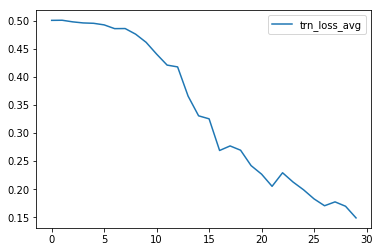

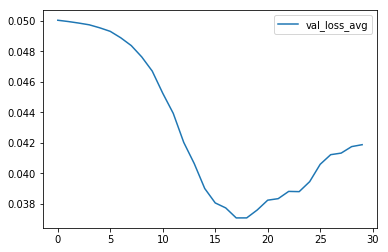

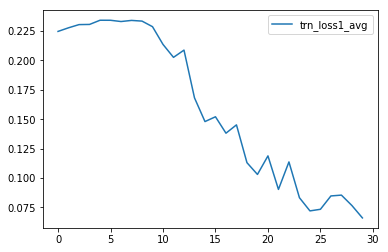

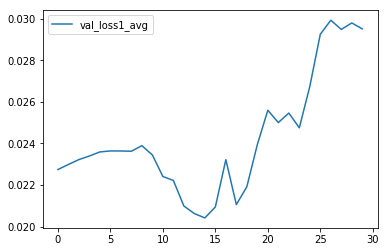

  epoch 2 


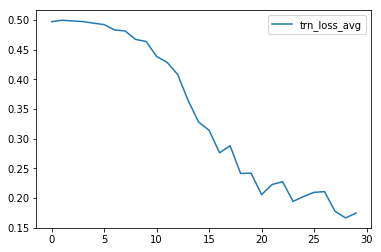

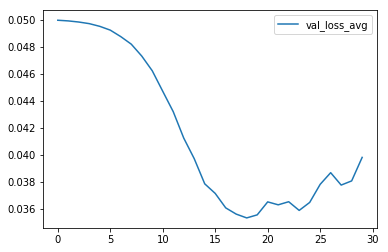

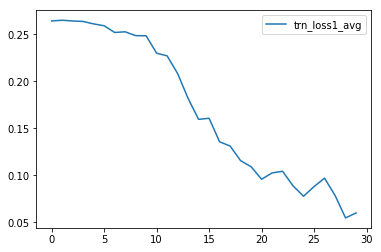

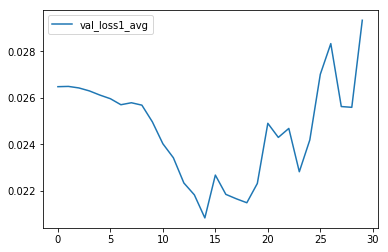

  epoch 3 


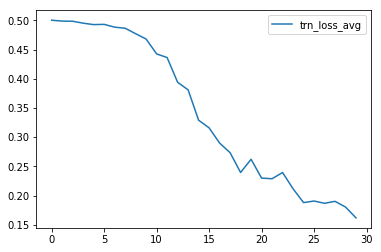

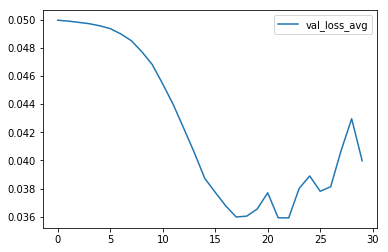

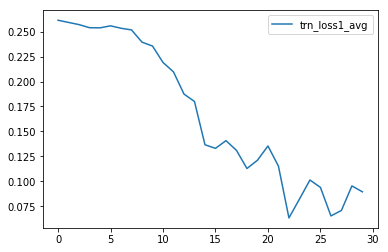

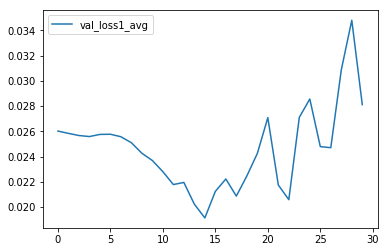

  epoch 4 


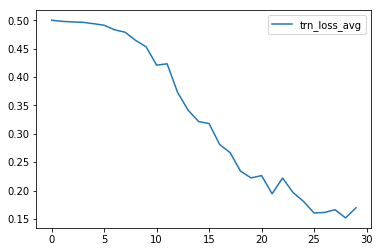

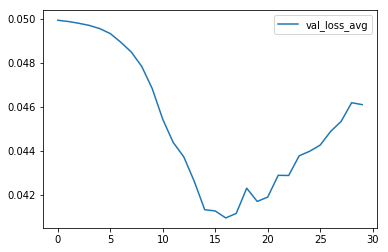

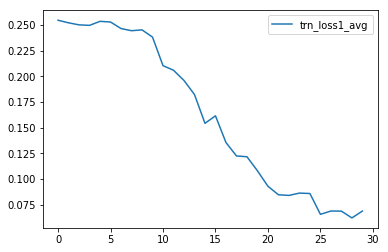

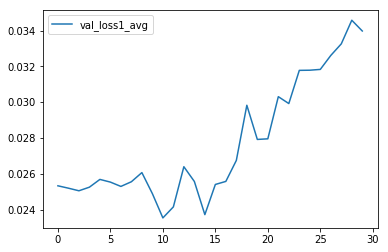

  epoch 5 


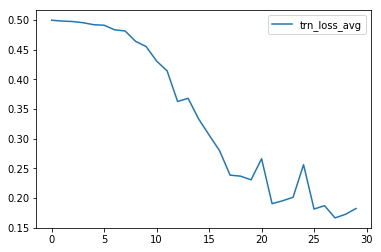

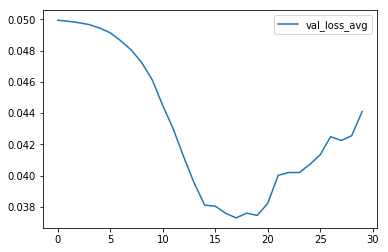

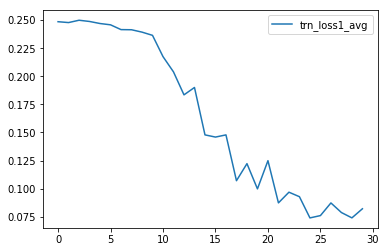

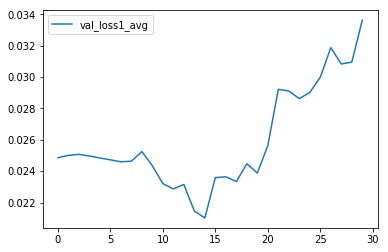

In [226]:

for i in range(5):
    trn_df = train_df.iloc[
        trn_idx[i],:
    ]
    val_df = train_df.iloc[
        val_idx[i],:
    ]

    trn_X, trn_y = trn_df[feature].values.tolist(),trn_df[['jobflag_2']].values.tolist() 
    val_X, val_y = val_df[feature].values.tolist(),val_df[['jobflag_2']].values.tolist() 


    trn_data_set = CreateDataset(trn_X, trn_y)
    val_data_set = CreateDataset(val_X, val_y)
    trn_dataloader = DataLoader(trn_data_set, shuffle=False, batch_size=256, sampler=ImbalancedDatasetSampler(trn_data_set))
    val_dataloader = DataLoader(val_data_set, shuffle=False, batch_size=len(val_data_set))

    model = MLPClass(len(feature), output_size=1)
    criterion = CustomLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=7e-4, weight_decay=0.0005)
    #optimizer = optim.SGD(params=model.parameters(), lr=7e-4, weight_decay=0.0005)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    trn_loss_list=[]
    val_loss_list=[]
    trn_loss1_list=[]
    val_loss1_list=[]


    for e in range(30):
        trn_loss_avg=0
        val_loss_avg=0
        trn_loss1_avg=0
        val_loss1_avg=0

        model.train()
        for data in trn_dataloader:
            optimizer.zero_grad()
            x = data['input']
            label = data['label'].squeeze(1)
            x = model(x).squeeze(1)
            loss, loss_1 = criterion(x, label)
            loss.backward()
            optimizer.step()
            scheduler.step()
            trn_loss1_avg+=loss_1/len(trn_dataloader)
            trn_loss_avg+=loss.item()/len(trn_dataloader)  

        model.eval()
        for data in val_dataloader:
            x = data['input']
            label = data['label'].squeeze(1)
            x = model(x).squeeze(1)
            loss, loss_1 = criterion(x, label)
            val_loss1_avg+=loss_1/len(trn_dataloader)
            val_loss_avg+=loss.item()/len(trn_dataloader) 

        trn_loss_list.append(trn_loss_avg)
        trn_loss1_list.append(trn_loss1_avg)
        val_loss_list.append(val_loss_avg)
        val_loss1_list.append(val_loss1_avg)
    
    print(f'  epoch {i+1} ')
    plt.plot(trn_loss_list, label='trn_loss_avg')
    plt.legend()
    plt.show()


    plt.plot(val_loss_list, label='val_loss_avg')
    plt.legend()
    plt.show()

    plt.plot(trn_loss1_list, label='trn_loss1_avg')
    plt.legend()
    plt.show()

    plt.plot(val_loss1_list, label='val_loss1_avg')
    plt.legend()
    plt.show()

    """print(f'epoch {e+1}')
        print(f'trn_loss_avg {trn_loss_avg} trn_loss1_avg {trn_loss1_avg}')
        print(f'val_loss_avg  {val_loss_avg} val_loss1_avg  {val_loss1_avg}') 

        if e%4==0:
            pred=[]
            for data in val_dataloader:
                x = data['input']
                label = data['label'].squeeze(1)
                pred += model(x).squeeze(1).tolist()
            val_df['pred'] = pred
            plt.figure(figsize=(30,10))
            sns.distplot(val_df[val_df.jobflag==1]['pred'], label='label 1')
            sns.distplot(val_df[val_df.jobflag==2]['pred'], label='label 2')
            sns.distplot(val_df[val_df.jobflag==3]['pred'], label='label 3')
            sns.distplot(val_df[val_df.jobflag==4]['pred'], label='label 4')
            plt.legend()
            plt.show()



    plt.figure(figsize=(30,10))
    pred=[]
    for data in val_dataloader:
        x = data['input']
        label = data['label'].squeeze(1)
        pred += model(x).squeeze(1).tolist()
    val_df['pred'] = pred
    sns.distplot(val_df[val_df.jobflag==1]['pred'], label='label 1')
    sns.distplot(val_df[val_df.jobflag==2]['pred'], label='label 2')
    sns.distplot(val_df[val_df.jobflag==3]['pred'], label='label 3')
    sns.distplot(val_df[val_df.jobflag==4]['pred'], label='label 4')
    plt.legend()
    plt.show()"""

In [228]:
#15~22